In [12]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [34]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

teams_df = pd.read_csv('/content/drive/My Drive/Teams.csv')

# Preprocess
df = teams_df[['year', 'franchID', 'W', 'G', 'GF', 'GA']].dropna()
df = df[df['G'] > 0]
df = df[df['year'] >= 1967]
df['win_pct'] = df['W'] / df['G']
df = df.sort_values(by=['franchID', 'year'])
df['prev_win_pct'] = df.groupby('franchID')['win_pct'].shift(1)
df['prev_GF'] = df.groupby('franchID')['GF'].shift(1)
df['prev_GA'] = df.groupby('franchID')['GA'].shift(1)
df['win_pct_change'] = df['win_pct'] - df['prev_win_pct']
df = df.dropna(subset=['prev_win_pct', 'prev_GF', 'prev_GA', 'win_pct_change'])

# Improved if win_pct increased by more than 10%
df['improved'] = (df['win_pct_change'] > 0.1).astype(int)

In [35]:
from sklearn.model_selection import StratifiedKFold

# Train and evaluate each model
feature_sets = {
    "Top 1 Feature": ['prev_win_pct'],
    "Top 2 Features": ['prev_win_pct', 'prev_GA'],
    "All 3 Features": ['prev_win_pct', 'prev_GF', 'prev_GA']
}

n_runs = 200  # Total evaluations = 200 * 5 = 1000
skf = StratifiedKFold(n_splits=5, shuffle=True)

avg_f1_scores = {}

for name, features in feature_sets.items():
    f1_scores = []

    for _ in range(n_runs):
        for train_idx, test_idx in skf.split(df[features], df['improved']):
            X_train = df.iloc[train_idx][features]
            y_train = df.iloc[train_idx]['improved']
            X_test = df.iloc[test_idx][features]
            y_test = df.iloc[test_idx]['improved']

            model = RandomForestClassifier(n_estimators=100)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
            f1_improved = report['1']['f1-score']
            f1_scores.append(f1_improved)

    avg_f1_scores[name] = np.mean(f1_scores)

for name, f1 in avg_f1_scores.items():
    print(f"{name}: Average F1 Score (Class 'Improved') = {f1:.4f}")

Top 1 Feature: Average F1 Score (Class 'Improved') = 0.1346
Top 2 Features: Average F1 Score (Class 'Improved') = 0.1944
All 3 Features: Average F1 Score (Class 'Improved') = 0.1628


In [41]:
# Visualize best-performing model
X_best = df[['prev_win_pct', 'prev_GA']]
y_best = df['improved']
X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(X_best, y_best, test_size=0.2)

clf_best = RandomForestClassifier(n_estimators=100)
clf_best.fit(X_train_best, y_train_best)
y_pred_best = clf_best.predict(X_test_best)
print("Accuracy:", accuracy_score(y_test_best, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test_best, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test_best, y_pred_best))

Accuracy: 0.7980769230769231
Confusion Matrix:
 [[158  16]
 [ 26   8]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.88       174
           1       0.33      0.24      0.28        34

    accuracy                           0.80       208
   macro avg       0.60      0.57      0.58       208
weighted avg       0.77      0.80      0.78       208



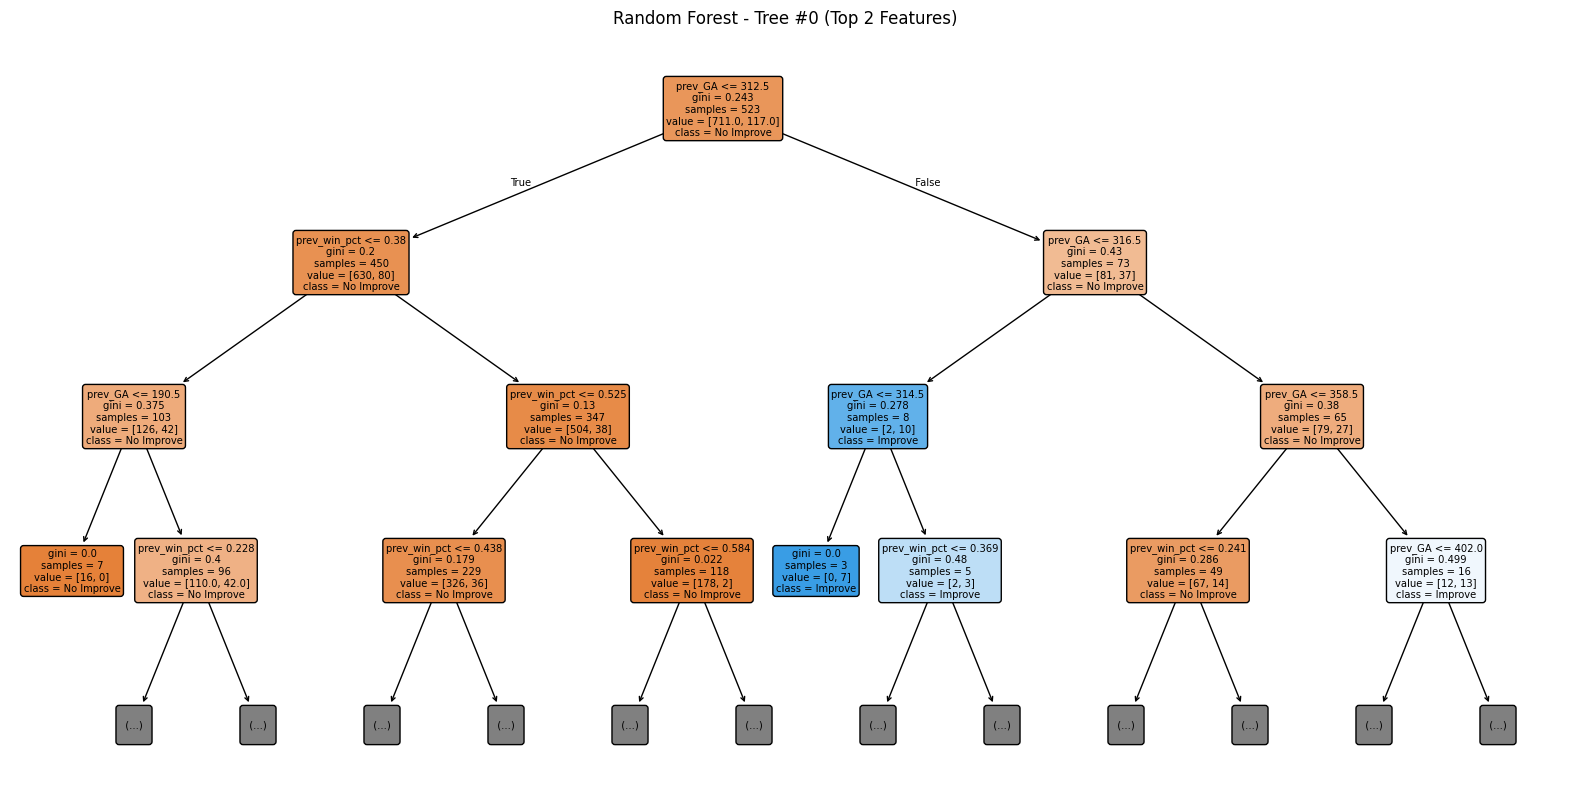

In [42]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(clf_best.estimators_[0],
          feature_names=X_best.columns,
          class_names=["No Improve", "Improve"],
          filled=True,
          rounded=True,
          max_depth=3)
plt.title("Random Forest - Tree #0 (Top 2 Features)")
plt.show()
